In [ ]:
%pip install tensorflow

In [24]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import numpy as np

In [25]:
#Run this command to access data from google drive in CoLab notebook
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# Make a shortcut from the "Shared with me" to your "My Drive" folder
%cd '/content/drive/My Drive/BreastLesionML'

/content/drive/.shortcut-targets-by-id/1lOR3gtDD2SuGv4J_Et_c-7b7Vi7eTfdc/BreastLesionML


In [27]:
# check gpu
print(tf.config.list_physical_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Num GPUs Available:  0


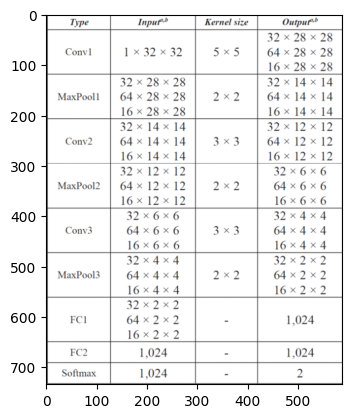

In [28]:
# https://ieeexplore.ieee.org/abstract/document/7440527
# we have changed our model
img = mpimg.imread('possible_model.png')
plt.imshow(img)
plt.show()

In [29]:
training_array_RAW = np.load('training_array_RAW.npy')
training_labels_array = np.load('training_labels_array.npy')
validation_array_RAW = np.load('validation_array_RAW.npy')
validation_labels_array = np.load('validation_labels_array.npy')

In [30]:
input_shape = (225, 225, 1)

model = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.InputLayer(input_shape=input_shape),
    # convolution 1:
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
    # tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
    # max pooling layer 1:
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    # convolution 2:
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
    # tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
    # max pooling layer 2:
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    # convolution 3:
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
    # tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
    # max pooling layer 3:
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    # dense layer:
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=3, activation='softmax')
])

In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # pick an optimizer
                     loss='sparse_categorical_crossentropy',  # pick a loss
                     metrics=['accuracy'])  # pick a metric to monitor

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 225, 225, 32)      832       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 32)      25632     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 32)        25632     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 28, 28, 32)       

In [32]:
hist = model.fit(training_array_RAW, training_labels_array,
              epochs=30,
              batch_size=32,
              validation_data=(validation_array_RAW, validation_labels_array))

Epoch 1/30


KeyboardInterrupt: 

NameError: name 'hist' is not defined

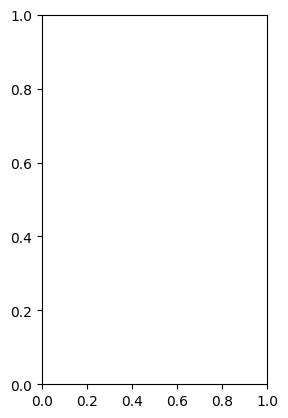

In [22]:
# TODO

# losses
plt.subplot(1,2,1)
plt.plot(np.arange(1,31,1), hist.history.get('loss'), label="Training Losses")
plt.plot(np.arange(1,31,1), hist.history.get('val_loss'), label="Validation Losses")
plt.grid(visible=True)
plt.title("Losses at Each Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

# accuracies
plt.subplot(1,2,2)
plt.plot(np.arange(1,31,1), hist.history.get('accuracy'), label="Training Accuracies")
plt.plot(np.arange(1,31,1), hist.history.get('val_accuracy'), label="Validation Accuracies")
plt.grid(visible=True)
plt.title("Accuracies at Each Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()

# show plots
plt.tight_layout()
plt.show()

In [33]:
# Define the SimpleCNN model from
class SimpleCNN(models.Model):
    def __init__(self, in_channels, n_classes, base_channels=64, dropout_p=-1, **kwargs):
        super(SimpleCNN, self).__init__()
        hidden_channels = [base_channels * k for k in [1, 2, 4, 4, 8]]

        self.layer1 = models.Sequential([
            layers.Conv2D(hidden_channels[0], kernel_size=3, padding='same', activation='relu', input_shape=(None, None, in_channels)),
            layers.BatchNormalization(),
            layers.MaxPool2D(pool_size=2, strides=2)
        ])

        self.layer2 = models.Sequential([
            layers.Conv2D(hidden_channels[1], kernel_size=3, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.Conv2D(hidden_channels[1], kernel_size=3, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool2D(pool_size=2, strides=2)
        ])

        self.layer3 = models.Sequential([
            layers.Conv2D(hidden_channels[2], kernel_size=3, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool2D(pool_size=2, strides=2)
        ])

        self.layer4 = models.Sequential([
            layers.Conv2D(hidden_channels[3], kernel_size=3, activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool2D(pool_size=2, strides=2)
        ])

        self.layer5 = models.Sequential([
            layers.Conv2D(hidden_channels[4], kernel_size=3, activation='relu'),
            layers.BatchNormalization(),
            layers.Conv2D(hidden_channels[4], kernel_size=3, padding='same', activation='relu'),
            layers.BatchNormalization()
        ])

        self.dropout_p = dropout_p
        if dropout_p > 0:
            self.dropout3 = layers.Dropout(dropout_p)
            self.dropout4 = layers.Dropout(dropout_p)
            self.dropout5 = layers.Dropout(dropout_p)
        else:
            self.dropout3 = layers.Lambda(lambda x: x)
            self.dropout4 = layers.Lambda(lambda x: x)
            self.dropout5 = layers.Lambda(lambda x: x)

        self.pool = layers.GlobalAveragePooling2D()
        self.fc = layers.Dense(n_classes, activation='softmax')

    def call(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.dropout3(x)
        x = self.layer4(x)
        x = self.dropout4(x)
        x = self.layer5(x)
        x = self.dropout5(x)
        x = self.pool(x)
        x = self.fc(x)
        return x

In [34]:
# Create an instance of the SimpleCNN model
simple_cnn_model = SimpleCNN(in_channels=1, n_classes=3, base_channels=64, dropout_p=0.5)

# Build the model by passing a sample input
sample_input = tf.keras.Input(shape=(None, None, 1))
simple_cnn_model(sample_input)

# Compile the model
simple_cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

# Print the model summary
simple_cnn_model.summary()

Model: "simple_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, None, None, 64)    896       
                                                                 
 sequential_4 (Sequential)   (None, None, None, 128)   222464    
                                                                 
 sequential_5 (Sequential)   (None, None, None, 256)   296192    
                                                                 
 sequential_6 (Sequential)   (None, None, None, 256)   591104    
                                                                 
 sequential_7 (Sequential)   (None, None, None, 512)   3544064   
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dropout_1 (Dropout)         multiple                  0

In [35]:
# Train the model
hist = model.fit(training_array_RAW, training_labels_array,
                 epochs=30,
                 batch_size=32,
                 validation_data=(validation_array_RAW, validation_labels_array))

Epoch 1/30
  1/100 [..............................] - ETA: 5:45 - loss: 0.4246 - accuracy: 0.9375

KeyboardInterrupt: 

NameError: name 'hist' is not defined

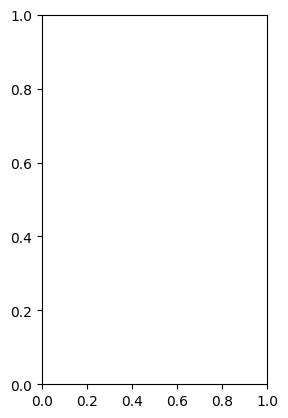

In [36]:
# Plot losses and accuracies
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, 31, 1), hist.history['loss'], label="Training Losses")
plt.plot(np.arange(1, 31, 1), hist.history['val_loss'], label="Validation Losses")
plt.grid(visible=True)
plt.title("Losses at Each Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, 31, 1), hist.history['accuracy'], label="Training Accuracies")
plt.plot(np.arange(1, 31, 1), hist.history['val_accuracy'], label="Validation Accuracies")
plt.grid(visible=True)
plt.title("Accuracies at Each Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()

In [37]:
def create_resnet50_model(input_shape, n_classes, dropout_p=0.5, base_model=None):
    if base_model is None:
        base_model = ResNet50(
            include_top=False,
            weights=None,
            input_shape=input_shape,
            pooling=None
        )

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    if dropout_p > 0:
        x = tf.keras.layers.Dropout(dropout_p)(x)

    predictions = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Set the input shape and number of classes
input_shape = (225, 225, 1)
n_classes = 3

In [38]:
# Create an instance of the ResNet50 model
resnet50_model = create_resnet50_model(input_shape, n_classes, dropout_p=0.5)

# Compile the model
resnet50_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

# Print the model summary
resnet50_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 225, 225, 1)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 231, 231, 1)          0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 113, 113, 64)         3200      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 113, 113, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [39]:
# Train the model
hist = resnet50_model.fit(training_array_RAW, training_labels_array,
                          epochs=30,
                          batch_size=32,
                          validation_data=(validation_array_RAW, validation_labels_array))

Epoch 1/30


Exception ignored in: <function _xla_gc_callback at 0x7ceadfdb2b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
# Plot losses and accuracies
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, 31, 1), hist.history['loss'], label="Training Losses")
plt.plot(np.arange(1, 31, 1), hist.history['val_loss'], label="Validation Losses")
plt.grid(visible=True)
plt.title("Losses at Each Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, 31, 1), hist.history['accuracy'], label="Training Accuracies")
plt.plot(np.arange(1, 31, 1), hist.history['val_accuracy'], label="Validation Accuracies")
plt.grid(visible=True)
plt.title("Accuracies at Each Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()